# Classification of MNIST digits with handcrafted features


Loading the image data



In [1]:
from keras.datasets import mnist
import numpy as np
from keras.utils import to_categorical
from keras import models
from keras import layers
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
(train_images_original, train_labels_original), (test_images_original, test_labels_original) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


Preparing the image data

In [3]:
train_images = train_images_original.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images_original.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

print(train_images.shape)
print(test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


Reshaping images into 1D vectors

In [4]:
train_vecs = train_images.reshape((60000, 28 * 28))
test_vecs = test_images.reshape((10000, 28 * 28))

print(train_vecs.shape)
print(test_vecs.shape)

(60000, 784)
(10000, 784)


Categorically encoding the labels.

In [5]:
train_labels = to_categorical(train_labels_original)
test_labels = to_categorical(test_labels_original)

print(train_labels.shape)
print(test_labels.shape)

(60000, 10)
(10000, 10)


### Calculating number of white regions in each image

I firstly rounded the pixel values in each image to either one or zero. This allows edges to be more strongly defined.

In [0]:
rounded = np.where(train_images > 0.3, 1, 0)
testing_rounded = np.where(test_images > 0.3, 1, 0)

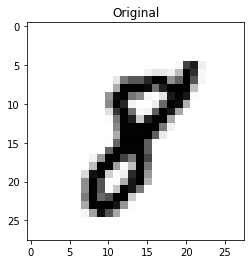

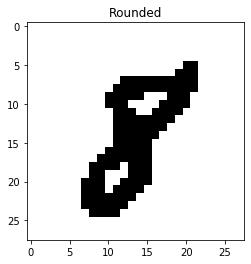

In [7]:
x = 17
plt.imshow(train_images.squeeze()[x], cmap='Greys')
plt.title('Original')
plt.show()
plt.imshow(rounded.squeeze()[x], cmap='Greys')
plt.title('Rounded')
plt.show()

Below is the function for calculating connected components

In [0]:
class Union_Find:
    # Union find data structure used to store parent->child region relationships

    def __init__(self):
        # Array which holds unique region labels
        self.R = []
        # Number of unique regions
        self.regions = 0

    def new_region(self):
        new_region = self.regions
        self.regions += 1
        self.R.append(new_region)
        return new_region
    
    # Set the root of a child node to a given parent node
    def set_root(self, i, root):
        while self.R[i] < i:
            j = self.R[i]
            self.R[i] = root
            i = j
        self.R[i] = root

    # Find the root node of a given node
    def find_root(self, i):
        while self.R[i] < i:
            i = self.R[i]
        return i
    
    # Find the root of a given node
    def find(self, i):
        root = self.find_root(i)
        self.set_root(i, root)
        return root
    
    # Connects the trees of 2 given nodes by one root node
    def connect(self, i, j):
        if i != j:
            root = self.find_root(i)
            rootj = self.find_root(j)
            if root > rootj: root = rootj
            self.set_root(j, root)
            self.set_root(i, root)
    
    def flatten(self):
        for i in range(1, len(self.R)):
            self.R[i] = self.R[self.R[i]]

def CCL(image):
    # Implements 8-connectivity connected component labeling
    image = image.squeeze()
    width, height = image.shape[1], image.shape[0]
 
    # Union find data structure used to track parent-child relationships
    union_find = Union_Find()
 
    # Regions image
    regions = np.zeros_like(image)

    # First pass
    for y in range(height):
      for x in range(width):
 
        # Ignore pixel if it is white
        if image[x, y] == 1:
            pass
 
        # check for connection between current and top pixel
        elif y > 0 and image[x, y-1] == 0:
            regions[x, y] = regions[x, y-1]
 
        # check for connection between current and top-right pixel
        elif x+1 < width and y > 0 and image[x+1, y-1] == 0:
 
            regions[x, y] = regions[x+1, y-1]
 
            # track possible connection between top left and top right pixels through the current pixel
            if x > 0 and image[x-1, y-1] == 0:
                union_find.connect(regions[x+1, y-1], regions[x-1, y-1])
 
            # track possible connection between left and top right pixels through the current pixel
            elif x > 0 and image[x-1, y] == 0:
                union_find.connect(regions[x+1, y-1], regions[x-1, y])
 
        # check for connection between current and top-left pixels
        elif x > 0 and y > 0 and image[x-1, y-1] == 0:
            regions[x, y] = regions[x-1, y-1]
 
        # check for connection between current and left pixels
        elif x > 0 and image[x-1, y] == 0:
            regions[x, y] = regions[x-1, y]
 
        # Create a new region if no connections found
        else: 
            regions[x, y] = union_find.new_region()
 
    union_find.flatten()

    # Second pass to connect child components with their parents, using union-find data structure
    for y in range(height):
      for x in range(width):
        
        # Find root parent of the current pixel and update its label accordingly
        regions[x, y] = union_find.find(regions[x, y])
    
    # Cleaning up and getting number of white regions
    regions = np.where(image == 1, 0, regions + 1)
    num_white_regions = len(np.unique(regions)) - 1

    return regions, num_white_regions

Testing my connected components function

There are 3 white regions in this image


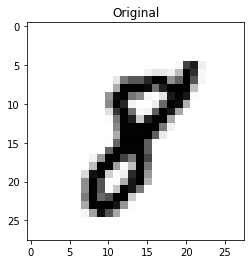

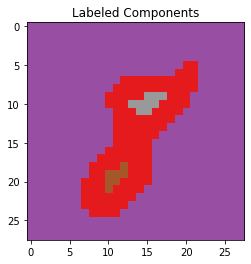

In [9]:
# Sample image
img = rounded[x]

# Run CLL
labeled, num_regions = CCL(img)
print('There are {} white regions in this image'.format(num_regions))
plt.imshow(train_images.squeeze()[x], cmap='Greys')
plt.title('Original')
plt.show()

plt.imshow(labeled, cmap='Set1')
plt.title('Labeled Components')
plt.show()

Running this function on all the images, getting us a length 60000 vector of the number of white regions in each training image

In [10]:
white_regions = []
for image in rounded:
  labeled, num_regions = CCL(image)
  white_regions.append(num_regions)

white_regions = np.array(white_regions).reshape((-1, 1))
print(white_regions.shape)

testing_white_regions = []
for image in testing_rounded:
  labeled, num_regions = CCL(image)
  testing_white_regions.append(num_regions)

testing_white_regions = np.array(testing_white_regions).reshape((-1, 1))
print(testing_white_regions.shape)

(60000, 1)
(10000, 1)


### Calculating height and width of each image

I then created a function which calculates the width of each image, as well as the positions in each image where the left and right edges occur. 

This results in 28 values representing the columns where the left edge occurs, another 28 for the right edge, and a final scalar for the maximum width of the image. These are all concatenated into a 57 length feature vector for the image

In [0]:
def get_width(image):
  image = image.squeeze()
  flipped = np.flip(image, axis = 1)

  # Using argmax to get the right-most pixel of the digit in each row
  left_edge = np.argmax(image, axis = 1)

  # Getting the left-most pixel of the digit in each row
  right_edge = len(image) - np.argmax(flipped, axis = 1) - 1
  right_edge = np.where(right_edge >= 27, 0, right_edge)

  # Getting the maximum width of the digit
  width = np.max(right_edge[np.nonzero(right_edge)]) - np.min(left_edge[np.nonzero(left_edge)])
  
  # Creating 57 length feature vector
  features = np.concatenate((left_edge, right_edge, [width])) / 28

  return features, left_edge, right_edge, width

Testing the width function. As you can see, my function allows us to understand where the left and right edges occur.

This image is 14 pixels wide. Below is the original image, then the left edge, then right edge, and finally the horizontally highlighted image


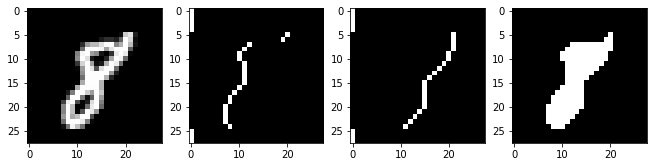

In [12]:
width_features, left_edge, right_edge, width = get_width(rounded[x])

left = np.zeros((28,28))
right = np.zeros((28,28))
highlight = np.zeros((28,28))

for i, row in enumerate(left):
  row[left_edge[i]] = 1
  left[i] = row

for i, row in enumerate(right):
  row[right_edge[i]] = 1
  right[i] = row

for i, row in enumerate(highlight):
  row[left_edge[i]:right_edge[i]] = 1
  highlight[i] = row

print('This image is {} pixels wide. Below is the original image, then the left edge, then right edge, and finally the horizontally highlighted image'.format(width))

fig = plt.figure(10, (14,14))
for i, img in enumerate([train_images[x].squeeze(), left, right, highlight]):
    ax = plt.subplot(2,5,i+1)
    ax.imshow(img, cmap='gray')

I then create a function the same as above, except this time for the height, top and bottom edge of the image

In [0]:
def get_height(image):
  image = image.squeeze()
  flipped = np.flip(image, axis = 0)

  # Using argmax to get the top-most pixel of the digit in each column
  top_edge = np.argmax(image, axis = 0)

  # Getting bottom-most pixel of the digit in each column
  bottom_edge = len(image) - np.argmax(flipped, axis = 0) - 1
  bottom_edge = np.where(bottom_edge >= 27, 0, bottom_edge)

  # Getting max height of the digit
  height = np.max(bottom_edge[np.nonzero(bottom_edge)]) - np.min(top_edge[np.nonzero(top_edge)])
  
  # Creating 57 length feature vector
  features = np.concatenate((bottom_edge, top_edge, [height])) / 28

  return features, bottom_edge, top_edge, height

Testing height function

This image is 19 pixels tall. Below is the original image, then the bottom edge, then top edge, and finally the vertically highlighted image


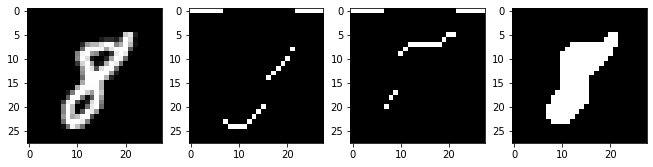

In [14]:
height_features, bottom_edge, top_edge, height = get_height(rounded[x])

highlight = np.zeros((28,28))
top = np.zeros((28,28))
bottom = np.zeros((28,28))

for i, column in enumerate(bottom.T):
  column[bottom_edge[i]] = 1
  bottom[:, i] = column

for i, column in enumerate(top.T):
  column[top_edge[i]] = 1
  top[:, i] = column

for i, column in enumerate(highlight.T):
  column[top_edge[i]:bottom_edge[i]] = 1
  highlight[:, i] = column

print('This image is {} pixels tall. Below is the original image, then the bottom edge, then top edge, and finally the vertically highlighted image'.format(height))

fig = plt.figure(10, (14,14))
for i, img in enumerate([train_images[x].squeeze(), bottom, top, highlight]):
    ax = plt.subplot(2,5,i+1)
    ax.imshow(img, cmap='gray')

I then run the width and height functions across all images. Both of these functions return a 57 length feature vector for each image.

In [15]:
width_features = []
height_features = []

for image in rounded:
  width_feats, left_edge, right_edge, width = get_width(image)
  height_feats, bottom_edge, top_edge, height = get_height(image)

  width_features.append(width_feats)
  height_features.append(height_feats)

width_features = np.array(width_features)
height_features = np.array(height_features)
print('Width features for training images: ' + str(width_features.shape))
print('Height features for training images: ' + str(height_features.shape))

testing_width_features = []
testing_height_features = []

for image in testing_rounded:
  width_feats, left_edge, right_edge, width = get_width(image)
  height_feats, bottom_edge, top_edge, height = get_height(image)

  testing_width_features.append(width_feats)
  testing_height_features.append(height_feats)

testing_width_features = np.array(testing_width_features)
testing_height_features = np.array(testing_height_features)
print('Width features for testing images: ' + str(testing_width_features.shape))
print('Height features for testing images: ' + str(testing_height_features.shape))

Width features for training images: (60000, 57)
Height features for training images: (60000, 57)
Width features for testing images: (10000, 57)
Height features for testing images: (10000, 57)


### Creating feature vectors

Concatenating our handcrafted features to the training image vectors, creating our final feature vectors

In [16]:
print('Training: \n')
print('Before adding handcrafted features to the image vectors: ' + str(train_vecs.shape))
train_vecs_handcrafted = np.concatenate((train_vecs, white_regions, width_features, height_features), axis = 1)
print('After adding handcrafted features: ' + str(train_vecs_handcrafted.shape))

print('\nTesting: \n')
print('Before adding handcrafted features to the image vectors: ' + str(test_vecs.shape))
test_vecs_handcrafted = np.concatenate((test_vecs, testing_white_regions, testing_width_features, testing_height_features), axis = 1)
print('After adding handcrafted features: ' + str(test_vecs_handcrafted.shape))

Training: 

Before adding handcrafted features to the image vectors: (60000, 784)
After adding handcrafted features: (60000, 899)

Testing: 

Before adding handcrafted features to the image vectors: (10000, 784)
After adding handcrafted features: (10000, 899)


### Baseline model

The network architecture - single dense layer

In [17]:
batch_size = 32
epochs = 10

model = models.Sequential()
model.add(layers.Dense(10, activation='softmax', input_shape=(28 * 28,)))
model.summary()

model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________




Below is our baseline model, **training only on the original image vectors**

In [18]:
history = model.fit(train_vecs, 
                    train_labels, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(test_vecs, test_labels))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 60000 samples, validate on 10000 samples
Epoch 1/10





60000/60000 [==============================] - 12s 197us/step - loss: 0.4638 - acc: 0.8793 - val_loss: 0.3062 - val_acc: 0.9151
Epoch 2/10
60000/60000 [==============================] - 7s 125us/step - loss: 0.3036 - acc: 0.9148 - val_loss: 0.2802 - val_acc: 0.9224
Epoch 3/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.2830 - acc: 0.9201 - val_loss: 0.2737 - val_acc: 0.9243
Epoch 4/10
60000/60000 [==============================] - 7s 120us/step - loss: 0.2729 - acc: 0.9237 - val_loss: 0.2701 - val_acc: 0.9253
Epoch 5/10
60000/60000 [==============================] - 7s 121us/step - loss: 0.2664 - acc: 0.9254 - val_loss: 0.2763 - val_acc: 0.9221
Epoch 6/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.2618 - acc: 0.9269 - val_loss: 0.2674 - val_acc: 0.9256
Epoch 7/10
60000/60

In [19]:
test_loss, test_acc = model.evaluate(test_vecs, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 44us/step
Test accuracy: 0.927


### Improved model using handcrafted features

Train model using image vectors **and additional hand crafted features**

In [20]:
batch_size = 32
epochs = 10

model = models.Sequential()
model.add(layers.Dense(10, activation='softmax', input_shape=(28 * 28 + 1 + 57 + 57,)))
model.summary()

model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                9000      
Total params: 9,000
Trainable params: 9,000
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(train_vecs_handcrafted, 
                    train_labels, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(test_vecs_handcrafted, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 129us/step - loss: 0.3951 - acc: 0.8976 - val_loss: 0.2296 - val_acc: 0.9370
Epoch 2/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.2150 - acc: 0.9391 - val_loss: 0.1962 - val_acc: 0.9463
Epoch 3/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.1855 - acc: 0.9477 - val_loss: 0.1747 - val_acc: 0.9523
Epoch 4/10
60000/60000 [==============================] - 7s 125us/step - loss: 0.1692 - acc: 0.9522 - val_loss: 0.1667 - val_acc: 0.9531
Epoch 5/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.1583 - acc: 0.9550 - val_loss: 0.1578 - val_acc: 0.9550
Epoch 6/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.1509 - acc: 0.9566 - val_loss: 0.1515 - val_acc: 0.9584
Epoch 7/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.1447 - acc: 0.9582 - val_loss: 0.1546 - 

As you can see below, we're able to boost the validation accuracy to 96% after utilizing our handcrafted features!

In [22]:
test_loss, test_acc = model.evaluate(test_vecs_handcrafted, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 47us/step
Test accuracy: 0.9606


Display the training/test loss/accuracy

In [0]:
history_dict = history.history
loss_values = history_dict['loss']
test_loss_values = history_dict['val_loss']
epochs_range = range(1, epochs + 1)

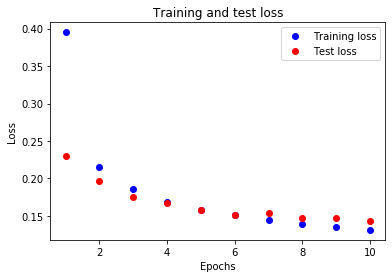

In [24]:
plt.plot(epochs_range, loss_values, 'bo', label='Training loss')
plt.plot(epochs_range, test_loss_values, 'ro', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
acc_values = history_dict['acc']
test_acc_values = history_dict['val_acc']

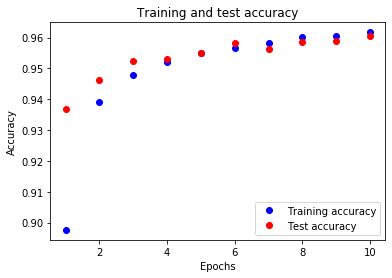

In [26]:
plt.plot(epochs_range, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs_range, test_acc_values, 'ro', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Visualizing predictions

In [0]:
preds = model.predict(test_vecs_handcrafted)

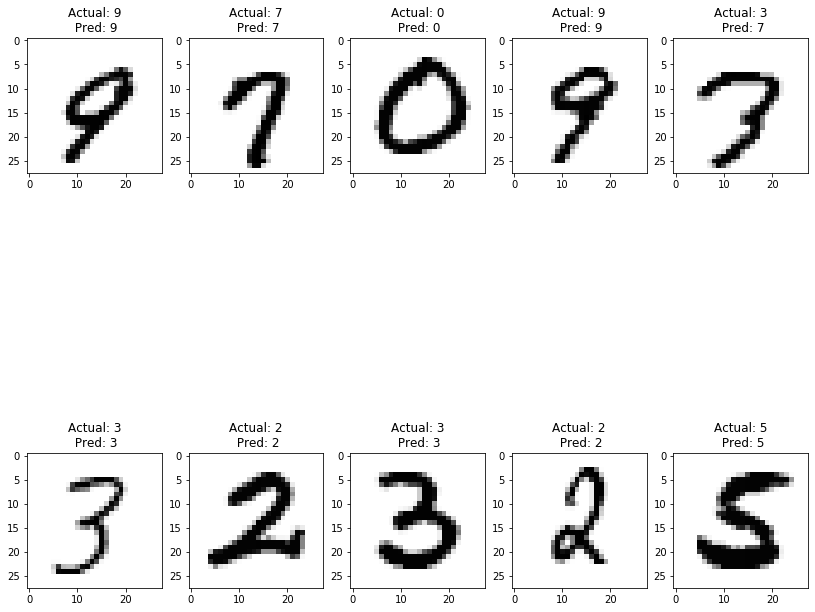

In [28]:
# Plotting some predictions
fig = plt.figure(10, (14,14))

for i in range(10):
    x = np.random.randint(0, 10000)
    ax = plt.subplot(2,5,i+1)
    ax.imshow(test_images[x].squeeze(), cmap='Greys')
    actual = np.argmax(test_labels[x])
    pred = np.argmax(preds[x])
    ax.set_title('Actual: {}\n Pred: {}'.format(actual, pred))